In [1]:
import numpy as np
import math
from scipy.linalg import block_diag
from collections import deque

In [2]:
# ----------------------------------------------- AUXILIAR FUNCTIONS ----------------------------------------------- #

# Binomial term
def binomial(k, i, eta):
    return (math.factorial(i) / (math.factorial(k) * math.factorial(i - k))) * (eta ** (i - k)) * ((1 - eta) ** k)

# General matrix of the Kraus operators
def kraus(n, k, eta):
    n, k = int(n), int(k)

    # Phase encoding
    diag_phase = [np.exp(1j * 0 * i) for i in range(0, n + 1)]
    u_phase = np.diag(diag_phase)

    # Loss encoding
    diagonal_elements = [np.sqrt(binomial(k, i, eta)) for i in range(k, n + 1)]
    diagonal_matrix = np.diag(diagonal_elements)
    zeros_matrix = np.zeros((n - k + 1, k))
    b = np.hstack((zeros_matrix, diagonal_matrix))

    return b @ u_phase

# Eigenmatrix of the phase derivative of the Kraus operators
def gamma_phase(n, k):
    n, k = int(n), int(k)

    # Auxiliar matrices for the gamma matrices
    zeros_matrix = np.zeros((n - k + 1, k))
    ident_elements = [1 for i in range(k, n + 1)]
    ident_matrix = np.diag(ident_elements)
    l_transf = np.hstack((zeros_matrix, ident_matrix))
    r_transf = np.transpose(l_transf)

    # Gamma matrix for the phase
    diag_lamb0_phase = [1j * i for i in range(0, n + 1)]
    array_lamb0_phase = np.diag(diag_lamb0_phase)
    gamma_0_phase = np.matrix(array_lamb0_phase)

    return l_transf @ gamma_0_phase @ r_transf

# Auxiliar matrices for the loss derivative of the Kraus operators
def gamma_loss(n, k, eta):
    n, k = int(n), int(k)

    # Auxiliar matrices for the gamma matrices
    zeros_matrix = np.zeros((n - k + 1, k))
    ident_elements = [1 for i in range(k, n + 1)]
    ident_matrix = np.diag(ident_elements)
    l_transf = np.hstack((zeros_matrix, ident_matrix))
    r_transf = np.transpose(l_transf)

    # Gamma matrix for the loss
    diag_lamb0_loss = [(i * (1 - eta) - k) for i in range(0, n + 1)]
    array_lamb0_loss = np.diag(diag_lamb0_loss)
    gamma_0_loss = np.matrix(array_lamb0_loss)

    return (l_transf @ gamma_0_loss @ r_transf) / (2 * eta * (1 - eta))

In [3]:
# --------------------------------------------------- SINGLE-MODE STATE --------------------------------------------------- #

def sld(rho, drho, reg=1e-10):
    
    """
    Compute the Symmetric Logarithmic Derivative (SLD) for a given output density matrix rho
    and its derivative drho with respect to the corresponding parameter. 
    
    PARAMETERS:

    rho (ndarray) : density matrix at the output (i.e. after evolution on the quantum channel)
    
    drho (ndarray) : derivative of rho with respect to the parameter of interest
    
    reg (float) : regularization term, which is the minimum eigenvalue to keep 
        in the support of rho to avoid division by zero.
    
    OUTPUT:

    sld (ndarray) : Symmetric Logarithmic Derivative matrix.
    """

    # Eigendecomposition of rho
    eigvals, eigvecs = np.linalg.eigh(rho)

    # Regularize small eigenvalues
    eigvals = np.where(eigvals < 1e-12, reg, eigvals)
    dim = len(eigvals)

    # Compute SLD in the eigenbasis
    sld_support = np.zeros((dim, dim), dtype=complex)
    for i in range(dim):
        for j in range(dim):
            denom = eigvals[i] + eigvals[j]
            if denom > reg:
                vi = eigvecs[:, i]
                vj = eigvecs[:, j]
                sld_support[i, j] = (2 * (vi.conj().T @ drho @ vj) / denom).item()

    # Reconstruct full SLD in original basis
    sld = eigvecs @ sld_support @ eigvecs.conj().T

    """
    An alternative approach is to use the solve_sylvester function, which yields accurate results 
    in the regime of high losses (η ~ 0). However, it becomes unstable when the loss is small (η ~ 1),
    which can result in wrong results for certain values of photon number 'n'.
    If you choose this method, make sure to import it with:
    
    from scipy.linalg import solve_sylvester
    
    Then, compute the SLD as follows:

    sld = solve_sylvester(rho, rho, 2 * drho)
    """
    
    return (sld + sld.conj().T) / 2 

def matrix_sm(ket0, eta, x_phase, x_loss):

    """
    Calculate the matrix m_sm used to compute the normalized Quantum Fisher Information (QFI) for a single-mode probe 
    state undergoing phase shift and loss, as well as the Symmetric Logarithmic Derivatives (SLDs) for each parameter.

    PARAMETERS:

    ket0 (ndarray) : column vector representing the probe state in the Fock basis (shape: (n+1, 1)).
        
    eta (float) : loss parameter (transmissivity, 0 ≤ eta ≤ 1)
    
    x_phase (float) : weight assigned to the phase estimation.
        
    x_loss (float) : weight assigned to the loss estimation.

    OUTPUT:

    m_sm (ndarray) : matrix used to compute the weighted QFI via Tr(rho0 @ m_sm), including contributions from both phase and loss.
        
    rho (ndarray) : final density matrix after evolution through the lossy and phase-shifting channel.
        
    sld_phase (ndarray) : SLD with respect to the phase parameter.
        
    sld_loss (ndarray) : SLD with respect to the loss parameter.
    """

    # Maximum number of photons
    n = len(ket0)-1 

    # Initialize m matrices for phase and loss contributions
    m_phase_sm = np.zeros((n + 1, n + 1), dtype=complex)
    m_loss_sm = np.zeros((n + 1, n + 1), dtype=complex)

    # Loop over Kraus index k (represents the number of photons lost)
    for k in range(0, n + 1):

        # Density matrix before evolution 
        rho0 = ket0 @ ket0.conj().T

        # Initialize the matrices for the evolved state and its derivatives
        rho = np.zeros((n + 1, n + 1), dtype=complex)
        dphi_rho = np.zeros((n + 1, n + 1), dtype=complex)
        deta_rho = np.zeros((n + 1, n + 1), dtype=complex)

        # Construct evolved state and its parameter derivatives by summing over all loss events (i)
        for i in range(0, n + 1):

            # Kraus operators for the single-mode state
            zeros_v = np.zeros((i, n + 1))
            zeros_h = np.zeros((n - i + 1, i))
            kraus_sm = np.vstack((kraus(n, i, eta), zeros_v))

            # Eigenmatrix of the phase and loss derivative of the single-mode Kraus operators
            gamma_phase_sm = np.vstack((np.hstack((gamma_phase(n, i), zeros_h)), zeros_v))
            gamma_loss_sm = np.vstack((np.hstack((gamma_loss(n, i, eta), zeros_h)), zeros_v))

            # Apply the quantum channel and its derivatives
            rho += kraus_sm @ rho0 @ kraus_sm.conj().T
            dphi_rho += gamma_phase_sm @ kraus_sm @ rho0 @ kraus_sm.conj().T + kraus_sm @ rho0 @ (gamma_phase_sm @ kraus_sm).conj().T
            deta_rho += gamma_loss_sm @ kraus_sm @ rho0 @ kraus_sm.conj().T + kraus_sm @ rho0 @ (gamma_loss_sm @ kraus_sm).conj().T

        # Converting the general matrices to single-mode matrices
        zeros_v = np.zeros((k, n + 1))
        zeros_h = np.zeros((n - k + 1, k))
        kraus_sm = np.vstack((kraus(n, k, eta), zeros_v))
        h_kraus_sm = kraus_sm.conj().T
        gamma_phase_sm = np.vstack((np.hstack((gamma_phase(n, k), zeros_h)), zeros_v))
        gamma_loss_sm = np.vstack((np.hstack((gamma_loss(n, k, eta), zeros_h)), zeros_v))

        # SLDs for phase the phase and loss
        sld_phase = sld(rho, dphi_rho)
        sld_loss = sld(rho, deta_rho)

        # Calculation of m_phase_k
        dphi_kraus_sm = gamma_phase_sm @ kraus_sm
        h_dphi_kraus_sm = dphi_kraus_sm.conj().T
        m_phase_sm += 2 * (h_dphi_kraus_sm @ sld_phase @ kraus_sm + h_kraus_sm @ sld_phase @ dphi_kraus_sm) - h_kraus_sm @ sld_phase @ sld_phase @ kraus_sm

        # Calculation of m_loss_k
        deta_kraus_sm = gamma_loss_sm @ kraus_sm
        h_deta_kraus_sm = deta_kraus_sm.conj().T
        m_loss_sm += 2 * (h_deta_kraus_sm @ sld_loss @ kraus_sm + h_kraus_sm @ sld_loss @ deta_kraus_sm) - h_kraus_sm @ sld_loss @ sld_loss @ kraus_sm

    # Combine weighted contributions to obtain final m matrix
    m_sm = x_phase * m_phase_sm + x_loss * m_loss_sm

    return m_sm, rho, sld_phase, sld_loss

def optimization_nphotons_sm(n, eta, reg = 1e-8, stop = 5, tol = 0.0001):

    """
    Performs the iterative see-saw (ISS) optimization to find the single-mode quantum state (ket0) that 
    maximizes the normalized QFI for the simultaneous estimation of phase and loss.

    PARAMETERS:
    
    n (int) : maximum number of photons (Fock space truncation: dimension = n + 1)
    
    eta (float) : loss parameter (transmissivity, 0 ≤ eta ≤ 1)
    
    reg (float) : regularization factor to avoid instabilities

    stop (int) : number of collected result to ensure the stop condition  
    
    tol (float) : condition for the last results to stop  

    OUTPUT:
    
    result_phase (tuple) : (qfi_phase, ket0_phase) — the maximum QFI for phase estimation and the corresponding optimal probe state ket0_phase
    
    result_simultaneous (tuple) : (qfi_norm, qfi_phi_eta, incomp_phi_eta , ket0) — includes the normalized QFI for the simultaneous estimation, 
        off-diagonal QFI elements, incompatibility term Tr[rh0 @ [sld_phase, sld_loss]], and final the optimal sngle-mode state ket0
    
    result_iterations (tuple) : (qfi_norm_iterations, qfi_phi_eta_iterations) — lists of normalized QFI and off-diagonal QFI elements at each iteration 
    """

    # ---------------------------------------- Optimization for the phase estimation ---------------------------------------- #

    # Initial guess for the phase estimation
    n = int(n)
    ket0_phase = np.ones((n + 1, 1)) / np.sqrt(n + 1)
    previous_qfi_phase = deque(maxlen=stop)

    iteration = 0
    while True:

        # M matrix for the phase estimation
        m_phase,_,_,_ = matrix_sm(ket0_phase, eta, 1, 0)

        # Diagonalize M and extract the eigenvector with the largest eigenvalue
        eigenvalues_phase, eigenvectors_phase = np.linalg.eig(m_phase)
        index_largest_eigenvalue_phase = np.argmax(eigenvalues_phase)
        eigenvector_largest_phase = eigenvectors_phase[:, index_largest_eigenvalue_phase]
        ket0_phase = eigenvector_largest_phase.reshape(-1, 1) / np.linalg.norm(eigenvector_largest_phase)
        ket0_phase /= np.linalg.norm(ket0_phase)
        
        # Calculation of phase QFI
        rho0_phase = ket0_phase @ ket0_phase.conj().T
        qfi_phase = np.trace(rho0_phase @ m_phase)

        # Check convergence 
        previous_qfi_phase.append(qfi_phase)
        if len(previous_qfi_phase) >= stop:
            if all((qfi_phase - result) / result < tol for result in previous_qfi_phase):
                break

        iteration += 1

    result_phase = qfi_phase, ket0_phase

    # ------------------------------------- Optimization for the simultaneous estimation ------------------------------------ #

    # Initial guess for the simultaneous estimation
    ket0 = np.ones((n + 1, 1)) / np.sqrt(n + 1)
    previous_qfi = deque(maxlen=stop)

    # Initialization of the figure of merit QFIs in each iteration
    qfi_norm_iterations = []
    qfi_phi_eta_iterations = []

    iteration = 0
    while True:

        # Compute weighted M matrix including regularization
        norm_phase = 1 / qfi_phase
        norm_loss = (eta * (1 - eta)) / n
        m_norm, rho, sld_phase, sld_loss = matrix_sm(ket0, eta, norm_phase, norm_loss)
        m_norm += reg * np.eye(m_norm.shape[0])

        # Eigenvectors for simultaneous estimation
        eigenvalues, eigenvectors = np.linalg.eig(m_norm)
        index_largest_eigenvalue = np.argmax(eigenvalues)
        eigenvector_largest = eigenvectors[:, index_largest_eigenvalue]
        ket0 = eigenvector_largest.reshape(-1, 1) / np.linalg.norm(eigenvector_largest)
        ket0 /= np.linalg.norm(ket0)

        # Calculation of the normalized QFI
        rho0 = ket0 @ ket0.conj().T
        qfi_norm = 0.5 * np.trace(rho0 @ m_norm)
        qfi_norm_iterations.append(qfi_norm)

        # Calculation of the off-diagonal elements of the QFI matrix: Tr[rho {L_phi, L_eta}/2]
        anticomm_sld = sld_phase @ sld_loss + sld_loss @ sld_phase
        qfi_phi_eta = 0.5 * np.trace(rho @ anticomm_sld)
        qfi_phi_eta_iterations.append(qfi_phi_eta)

        # Calculation of the incompatibility term: Tr[rho [L_phi, L_eta]]
        comm_sld = sld_phase @ sld_loss - sld_loss @ sld_phase
        incomp_phi_eta = np.trace(rho @ comm_sld)

        # Check convergence 
        previous_qfi.append(qfi_norm)
        if len(previous_qfi) == stop:
            average_qfi = sum(previous_qfi) / len(previous_qfi)
            if abs(qfi_norm - average_qfi) < tol:
                break

        iteration += 1

    result_simultaneous = qfi_norm, qfi_phi_eta, incomp_phi_eta , ket0
    result_iterations = qfi_norm_iterations, qfi_phi_eta_iterations

    return result_phase, result_simultaneous, result_iterations

In [4]:
# ----------------------------------------------------- TWO-MODE STATE ----------------------------------------------------- #

def matrix_tm(ket0, eta, x_phase, x_loss, reg=1e-10):

    """
    Calculate the matrix m_tm used to compute the normalized Quantum Fisher Information (QFI) for a tw-mode probe 
    state undergoing phase shift and loss, as well as the Symmetric Logarithmic Derivatives (SLDs) for each parameter.

    PARAMETERS:

    ket0 (ndarray) : column vector representing the probe state in the Fock basis (shape: (n+1, 1)).
        
    eta (float) : loss parameter (transmissivity, 0 ≤ eta ≤ 1)
    
    x_phase (float) : weight assigned to the phase estimation.
        
    x_loss (float) : weight assigned to the loss estimation.

    OUTPUT:

    m_tm (ndarray) : matrix used to compute the weighted QFI via Tr(rho0 @ m_tm), including contributions from both phase and loss.
        
    rho (ndarray) : final density matrix after evolution through the lossy and phase-shifting channel.
        
    sld_phase (ndarray) : SLD with respect to the phase parameter.
        
    sld_loss (ndarray) : SLD with respect to the loss parameter.
    """

    # Total number of photons
    n = len(ket0)-1 

    # Initialize m matrices for phase and loss contributions
    m_phase_tm = np.zeros((n + 1, n + 1), dtype=complex)
    m_loss_tm = np.zeros((n + 1, n + 1), dtype=complex)

    # Density matrix before evolution
    rho0 = ket0 @ ket0.conj().T

    # # Initialize the matrices for the evolved state and the SLDs
    rho_blocks = []
    sld_phase_blocks = []
    sld_loss_blocks = []

    # Loop over Kraus index k (represents the number of photons lost)
    for k in range(0, n + 1):

        # Kraus and Gamma matrices for the two-mode state
        kraus_tm = kraus(n, k, eta)
        h_kraus_tm = kraus_tm.conj().T
        gamma_phase_tm = gamma_phase(n, k)
        gamma_loss_tm = gamma_loss(n, k, eta)

        # Density matrix at the blok "k" after evolution
        rho_k = kraus_tm @ rho0 @ kraus_tm.conj().T

        # Phase SLD (direct formula)
        pk = np.trace(rho_k)
        pk = pk if abs(pk) > reg else reg
        sld_phase_k = 2 * (gamma_phase_tm @ rho_k + rho_k @ gamma_phase_tm.conj()) / pk
        
        # Loss SLD (direct formula)
        der_pk = np.trace(np.conjugate(np.transpose(kraus_tm @ ket0)) @ (gamma_loss_tm.conj() + gamma_loss_tm) @ kraus_tm @ ket0)
        der_pk = der_pk if abs(der_pk) > reg else reg
        sld_loss_k = (2 * gamma_loss_tm @ rho_k + 2 * rho_k @ gamma_loss_tm.conj() - (der_pk / pk) * rho_k) / pk

        """
        An alternative way to compute the phase and loss SLDs is by using the 'sld' function, 
        as done for the single-mode state. However, this approach is generally slower than the 
        analytical method presented in the previous lines.

        # Phase SLD
        deta_rho_k = gamma_phase_tm @ rho_k + rho_k @ gamma_phase_tm.conj()
        sld_phase_k = sld(rho_k, deta_rho_k)
        
        # Loss SLD 
        dphi_rho_k = gamma_loss_tm @ rho_k + rho_k @ gamma_loss_tm.conj()
        sld_loss_k = sld(rho_k, dphi_rho_k)
        """

        # Calculation of m_phase_k
        dphi_kraus_tm = gamma_phase_tm @ kraus_tm
        h_dphi_kraus_tm = dphi_kraus_tm.conj().T
        m_phase_tm += 2 * (h_dphi_kraus_tm @ sld_phase_k @ kraus_tm + h_kraus_tm @ sld_phase_k @ dphi_kraus_tm) - h_kraus_tm @ sld_phase_k @ sld_phase_k @ kraus_tm
        
        # Calculation of m_loss_k
        deta_kraus_tm = gamma_loss_tm @ kraus_tm
        h_deta_kraus_tm = deta_kraus_tm.conj().T
        m_loss_tm += 2 * (h_deta_kraus_tm @ sld_loss_k @ kraus_tm + h_kraus_tm @ sld_loss_k @ deta_kraus_tm) - h_kraus_tm @ sld_loss_k @ sld_loss_k @ kraus_tm

        # Block matrices
        rho_blocks.append(rho_k)
        sld_phase_blocks.append(sld_phase_k)
        sld_loss_blocks.append(sld_loss_k)

    # Matrix M
    m_tm = x_phase * m_phase_tm + x_loss * m_loss_tm

    # Block matrices rho, sld_phase, sld_loss
    rho = block_diag(*rho_blocks)
    sld_phase = block_diag(*sld_phase_blocks)
    sld_loss = block_diag(*sld_loss_blocks)

    return m_tm, rho, sld_phase, sld_loss

# Optimization for the two-mode state
def optimization_nphotons_tm(n, eta, reg = 1e-8, stop = 5, tol = 0.0001):

    """
    Performs the iterative see-saw (ISS) optimization to find the two-mode quantum state (ket0) that 
    maximizes the normalized QFI for the simultaneous estimation of phase and loss.

    PARAMETERS:
    
    n (int) : total number of photons 
    
    eta (float) : loss parameter (transmissivity, 0 ≤ eta ≤ 1)

    reg (float) : regularization factor to avoid instabilities

    stop (int) : number of collected result to ensure the stop condition  
    
    tol (float) : condition for the last results to stop  

    OUTPUT:
    
    result_phase (tuple) : (qfi_phase, ket0_phase) — the maximum QFI for phase estimation and the corresponding optimal probe state ket0_phase
    
    result_simultaneous (tuple) : (qfi_norm, qfi_phi_eta, incomp_phi_eta , ket0) — includes the normalized QFI for the simultaneous estimation, 
        off-diagonal QFI elements, incompatibility term Tr[rh0 @ [sld_phase, sld_loss]], and final the optimal two-mode state ket0
    
    result_iterations (tuple) : (qfi_norm_iterations, qfi_phi_eta_iterations) — lists of normalized QFI and off-diagonal QFI elements at each iteration 
    """ 

    # ---------------------------------------- Optimization for the phase estimation ---------------------------------------- #

    # It is the phase normalization term at the normalized QFI

    # Initial guess for the phase estimation
    n = int(n)
    ket0_phase = np.ones((n + 1, 1)) / np.sqrt(n + 1)
    previous_qfi_phase = deque(maxlen=stop)

    # Iteration
    iteration = 0
    while True:

        # Normalized M matrix
        m_phase,_,_,_ = matrix_tm(ket0_phase, eta, 1, 0)

        # Eigenvectors for simultaneous estimation
        eigenvalues_phase, eigenvectors_phase = np.linalg.eig(m_phase)
        index_largest_eigenvalue_phase = np.argmax(eigenvalues_phase)
        eigenvector_largest_phase = eigenvectors_phase[:, index_largest_eigenvalue_phase]
        ket0_phase = eigenvector_largest_phase.reshape(-1, 1) / np.linalg.norm(eigenvector_largest_phase)

        # Calculation of normalized QFI
        rho0_phase = ket0_phase @ ket0_phase.conj().T
        qfi_phase = np.trace(rho0_phase @ m_phase)

        # Stop condition
        previous_qfi_phase.append(qfi_phase)
        if len(previous_qfi_phase) >= stop:
            if all((qfi_phase - result) / result < tol for result in previous_qfi_phase):
                break

        iteration += 1

    # Packing the results for the phase optimization
    result_phase = qfi_phase, ket0_phase

    # ------------------------------------- Optimization for the simultaneous estimation ------------------------------------ #


    # Initial guess for the simultaneous estimation
    ket0 = np.ones((n + 1, 1)) / np.sqrt(n + 1)
    previous_qfi = deque(maxlen=stop)

    # Array to store the values of the figure of merit QFIs in each iteration
    qfi_norm_iterations = []
    qfi_phi_eta_iterations =[]

    # Iteration
    iteration = 0
    while True:

        # Normalized M matrix
        norm_phase = 1 / qfi_phase
        norm_loss = (eta * (1 - eta)) / n
        m_norm, rho, sld_phase, sld_loss = matrix_tm(ket0, eta, norm_phase, norm_loss)
        m_norm += reg * np.eye(m_norm.shape[0])

        # Eigenvectors for simultaneous estimation
        eigenvalues, eigenvectors = np.linalg.eig(m_norm)
        index_largest_eigenvalue = np.argmax(eigenvalues)
        eigenvector_largest = eigenvectors[:, index_largest_eigenvalue]
        ket0 = eigenvector_largest.reshape(-1, 1) / np.linalg.norm(eigenvector_largest)

        # Calculation of normalized QFI
        rho0 = ket0 @ np.conjugate(np.transpose(ket0))
        qfi_norm = 0.5 * np.trace(rho0 @ m_norm)
        qfi_norm_iterations.append(qfi_norm)

        # Calculation of the off-diagonal elements of the QFI matrix
        anticomm_sld = sld_phase @ sld_loss + sld_loss @ sld_phase
        qfi_phi_eta = 0.5 * np.trace(rho @ anticomm_sld)
        qfi_phi_eta_iterations.append(qfi_phi_eta)

        # Calculation of the incompatibility term
        comm_sld = sld_phase @ sld_loss - sld_loss @ sld_phase
        incomp_phi_eta = np.trace(rho @ comm_sld)

        # Stop condition
        previous_qfi.append(qfi_norm)
        if len(previous_qfi) >= stop:
            if all((qfi_norm - result) / result < tol for result in previous_qfi):
                break

        iteration += 1

    # Packing the results for the simultaneous estimation: final result and in each iteration
    result_simultaneous = qfi_norm, qfi_phi_eta, incomp_phi_eta , ket0
    result_iterations = qfi_norm_iterations, qfi_phi_eta_iterations

    return result_phase, result_simultaneous, result_iterations

In [5]:
%%time

# ------------------------------------------------- EXAMPLE OF OPTIMIZATION ------------------------------------------------- #

"""
Example of the optimization process for both single-mode and two-mode states, considering two different 
values of loss eta = 0.1, 0.9. For each optimal state, we present the following quantities:
qfi_norm : normalized QFI 
qfi_phase : phase QFI
qfi_phi_eta : off-diaonal elements of the QFI matrix Tr[rh0 @ {sld_phase, sld_loss}]
incomp_phi_eta : incompatibility term Tr[rh0 @ [sld_phase, sld_loss]]
"""

# Values of the loss
eta_max, eta_min = 0.1, 0.9

# Values of the photon number (in log scale)
n_values = [5, 9, 16, 28, 52, 94]  

print('#-----------------------------------------------------------------------------------------------------------------#')
print('Single-mode state')
print('#-----------------------------------------------------------------------------------------------------------------#')

# Optimization for the single-mode state in the regime of big losses
print('Big loss: eta =', eta_max)
qfi_norm_sm_eta_max = []
qfi_phi_eta_sm_eta_max = []
for n in n_values:
    eta = eta_max
    result_phase, result_simultaneous, result_iterations = optimization_nphotons_sm(n, eta)
    qfi_phase, ket0_phase = result_phase
    qfi_norm, qfi_phi_eta, incomp_phi_eta , ket0  = result_simultaneous
    qfi_norm_iterations, qfi_phi_eta_iterations = result_iterations
    print('n =', n, ', qfi_norm =', np.round(qfi_norm, 6), ', qfi_phase =', np.round(qfi_phase, 6), ', qfi_phi_eta =', np.round(qfi_phi_eta, 6), ', incomp_phi_eta =', np.round(incomp_phi_eta, 6))

    # Collecting the results for the plot
    qfi_norm_sm_eta_max.append(qfi_norm_iterations)
    qfi_phi_eta_sm_eta_max.append(qfi_phi_eta_iterations)


# Optimization for the single-mode state in the regime of big losses
print('Small loss: eta =', eta_min)
qfi_norm_sm_eta_min = []
qfi_phi_eta_sm_eta_min = []
for n in n_values:
    eta = eta_min
    result_phase, result_simultaneous, result_iterations = optimization_nphotons_sm(n, eta)
    qfi_phase, ket0_phase = result_phase
    qfi_norm, qfi_phi_eta, incomp_phi_eta , ket0  = result_simultaneous
    qfi_norm_iterations, qfi_phi_eta_iterations = result_iterations
    print('n =', n, ', qfi_norm =', np.round(qfi_norm, 6), ', qfi_phase =', np.round(qfi_phase, 6), ', qfi_phi_eta =', np.round(qfi_phi_eta, 6), ', incomp_phi_eta =', np.round(incomp_phi_eta, 6))

    # Collecting the results for the plot
    qfi_norm_sm_eta_min.append(qfi_norm_iterations)
    qfi_phi_eta_sm_eta_min.append(qfi_phi_eta_iterations)


print('#-----------------------------------------------------------------------------------------------------------------#')
print('Two-mode state')
print('#-----------------------------------------------------------------------------------------------------------------#')

# Optimization for the two-mode state in the regime of big losses
print('Big loss: eta =', eta_max)
qfi_norm_tm_eta_max = []
qfi_phi_eta_tm_eta_max = []
for n in n_values:
    eta = eta_max
    result_phase, result_simultaneous, result_iterations = optimization_nphotons_tm(n, eta)
    qfi_phase, ket0_phase = result_phase
    qfi_norm, qfi_phi_eta, incomp_phi_eta , ket0  = result_simultaneous
    qfi_norm_iterations, qfi_phi_eta_iterations = result_iterations
    print('n =', n, ', qfi_norm =', np.round(qfi_norm, 6), ', qfi_phase =', np.round(qfi_phase, 6), ', qfi_phi_eta =', np.round(qfi_phi_eta, 6), ', incomp_phi_eta =', np.round(incomp_phi_eta, 6))

    # Collecting the results for the plot
    qfi_norm_tm_eta_max.append(qfi_norm_iterations)
    qfi_phi_eta_tm_eta_max.append(qfi_phi_eta_iterations)

# Optimization for the two-mode state in the regime of small losses
print('Small loss: eta =', eta_min)
qfi_norm_tm_eta_min = []
qfi_phi_eta_tm_eta_min = []
for n in n_values:
    eta = eta_min
    result_phase, result_simultaneous, result_iterations = optimization_nphotons_tm(n, eta)
    qfi_phase, ket0_phase = result_phase
    qfi_norm, qfi_phi_eta, incomp_phi_eta , ket0  = result_simultaneous
    qfi_norm_iterations, qfi_phi_eta_iterations = result_iterations
    print('n =', n, ', qfi_norm =', np.round(qfi_norm, 6), ', qfi_phase =', np.round(qfi_phase, 6), ', qfi_phi_eta =', np.round(qfi_phi_eta, 6), ', incomp_phi_eta =', np.round(incomp_phi_eta, 6))

    # Collecting the results for the plot
    qfi_norm_tm_eta_min.append(qfi_norm_iterations)
    qfi_phi_eta_tm_eta_min.append(qfi_phi_eta_iterations)


#-----------------------------------------------------------------------------------------------------------------#
Single-mode state
#-----------------------------------------------------------------------------------------------------------------#
Big loss: eta = 0.1
n = 5 , qfi_norm = (0.825898+0j) , qfi_phase = (0.925537+0j) , qfi_phi_eta = -0j , incomp_phi_eta = -9.671325j
n = 9 , qfi_norm = (0.840324+0j) , qfi_phase = (1.918037+0j) , qfi_phi_eta = 0j , incomp_phi_eta = -19.933553j
n = 16 , qfi_norm = (0.858284+0j) , qfi_phase = (3.837606+0j) , qfi_phi_eta = -0j , incomp_phi_eta = -39.500425j
n = 28 , qfi_norm = (0.876365+0j) , qfi_phase = (7.472439+0j) , qfi_phi_eta = -0j , incomp_phi_eta = -76.890082j
n = 52 , qfi_norm = (0.883733+0j) , qfi_phase = (15.252562+0j) , qfi_phi_eta = -0j , incomp_phi_eta = -155.313653j
n = 94 , qfi_norm = (0.894836+0j) , qfi_phase = (29.688129+0j) , qfi_phi_eta = -0j , incomp_phi_eta = -300.102877j
Small loss: eta = 0.9
n = 5 , qfi_norm = (0.8108+0j)

C:\Users\thiag\anaconda3\Lib\site-packages\matplotlib\cbook.py:1762: ComplexWarning: Casting complex values to real discards the imaginary part
  return math.isfinite(val)
C:\Users\thiag\anaconda3\Lib\site-packages\matplotlib\cbook.py:1398: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)
C:\Users\thiag\anaconda3\Lib\site-packages\matplotlib\cbook.py:1762: ComplexWarning: Casting complex values to real discards the imaginary part
  return math.isfinite(val)
C:\Users\thiag\anaconda3\Lib\site-packages\matplotlib\cbook.py:1398: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)
C:\Users\thiag\anaconda3\Lib\site-packages\matplotlib\cbook.py:1762: ComplexWarning: Casting complex values to real discards the imaginary part
  return math.isfinite(val)
C:\Users\thiag\anaconda3\Lib\site-packages\matplotlib\cbook.py:1398: ComplexWarning: Casting complex values to real discards the imagina

CPU times: total: 5.59 s
Wall time: 1min 5s


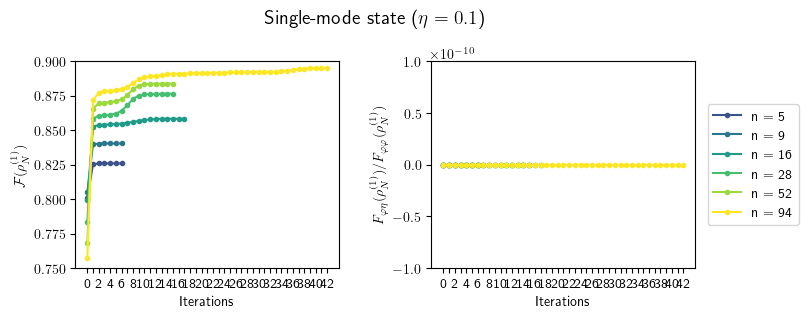

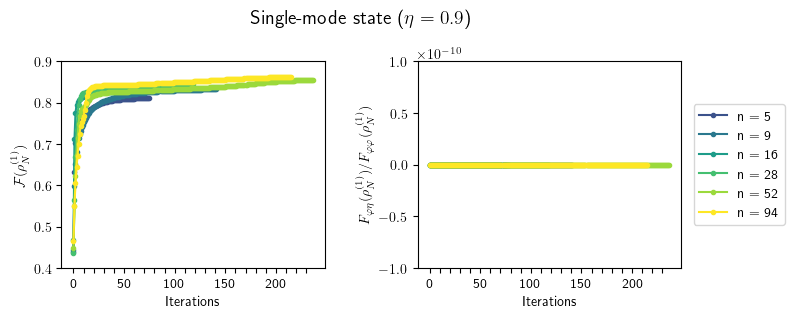

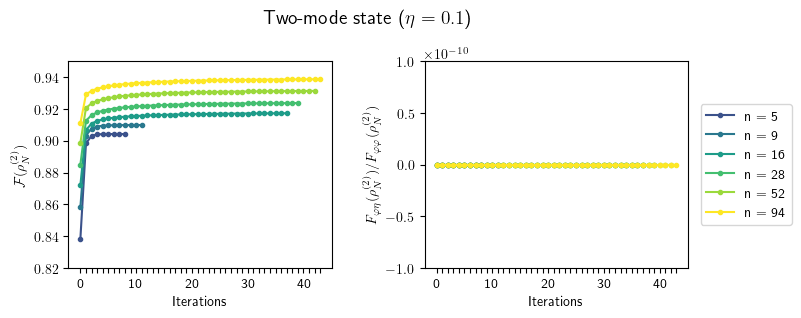

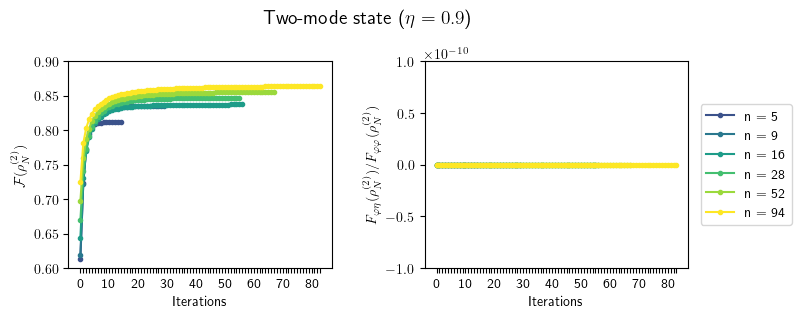

In [6]:
%%time

import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.ticker import FixedLocator, FuncFormatter

# ---------------------------------- PLOTS IN FUNCTION OF THE ITERATIONS ---------------------------------- #

# Generate the colors for the graphs
colormap = cm.viridis
colors = [colormap(i) for i in np.linspace(0.25, 1, len(n_values))]  

# -------------------------------------------------------------------------------------------------------- #

# Plots of the main results in function of the iterations (single-mode state in the regime of big losses)

plt.rc('text', usetex=True)
fig, axs = plt.subplots(1, 2, figsize=(8, 3))
for idx, (plot_sm1_eta_max, plot_sm2_eta_max, n) in enumerate(zip(qfi_norm_sm_eta_max, qfi_phi_eta_sm_eta_max, n_values)):
    axs[0].plot(range(len(plot_sm1_eta_max)), plot_sm1_eta_max, marker='.', color=colors[idx])
    axs[1].plot(range(len(plot_sm2_eta_max)), plot_sm2_eta_max, marker='.', color=colors[idx], label=f'n = {n}')

fig.text(0.5, 0.925, rf'Single-mode state ($\eta={eta_max}$)', ha='center', fontsize=14)

axs[0].set_xticks(range(len(plot_sm1_eta_max)))
axs[0].set_xticklabels([str(i) if i % 2 == 0 else '' for i in range(len(plot_sm1_eta_max))])
axs[0].set_xlabel(r'Iterations')
axs[0].set_ylabel(r'$\mathcal{F}(\rho^{(1)}_N)$')
axs[0].set_ylim(0.75, 0.9)

axs[1].set_xticks(range(len(plot_sm2_eta_max)))
axs[1].set_xticklabels([str(i) if i % 2 == 0 else '' for i in range(len(plot_sm2_eta_max))])
axs[1].set_xlabel(r'Iterations')
axs[1].set_ylabel(r'$F_{\varphi \eta}(\rho^{(1)}_N) /  F_{\varphi \varphi}(\rho^{(1)}_N)$')
axs[1].set_ylim(-10**(-10), 10**(-10))
axs[1].legend(loc='center left', bbox_to_anchor=(1.02, 0.5))

fig.subplots_adjust(top=0.8, hspace=0.6, wspace=0.35)

plt.savefig('optimization_iterations_sm_eta01.pdf', dpi=300, bbox_inches='tight')

# -------------------------------------------------------------------------------------------------------- #

# Plots of the main results in function of the iterations 

plt.rc('text', usetex=True)
fig, axs = plt.subplots(1, 2, figsize=(8, 3))
for idx, (plot_sm1_eta_min, plot_sm2_eta_min, n) in enumerate(zip(qfi_norm_sm_eta_min, qfi_phi_eta_sm_eta_min, n_values)):
    axs[0].plot(range(len(plot_sm1_eta_min)), plot_sm1_eta_min, marker='.', color=colors[idx])
    axs[1].plot(range(len(plot_sm2_eta_min)), plot_sm2_eta_min, marker='.', color=colors[idx], label=f'n = {n}')

fig.text(0.5, 0.925, rf'Single-mode state ($\eta={eta_min}$)', ha='center', fontsize=14)

len_max_sm2_eta_min = max(len(arr) for arr in qfi_phi_eta_sm_eta_min)
tick_positions_1 = np.arange(0, len_max_sm2_eta_min, 10)
axs[0].set_xticks(tick_positions_1)
axs[0].xaxis.set_major_formatter(FuncFormatter(lambda x, _: f"{int(x)}" if x % 50 == 0 else ""))
axs[0].set_xlabel(r'Iterations')
axs[0].set_ylabel(r'$\mathcal{F}(\rho^{(1)}_N)$')
axs[0].set_ylim(0.4, 0.9)

axs[1].set_xticks(tick_positions_1)
axs[1].xaxis.set_major_formatter(FuncFormatter(lambda x, _: f"{int(x)}" if x % 50 == 0 else ""))
axs[1].set_xlabel(r'Iterations')
axs[1].set_ylabel(r'$F_{\varphi \eta}(\rho^{(1)}_N) /  F_{\varphi \varphi}(\rho^{(1)}_N)$')
axs[1].set_ylim(-10**(-10), 10**(-10))
axs[1].legend(loc='center left', bbox_to_anchor=(1.02, 0.5))

fig.subplots_adjust(top=0.8, hspace=0.6, wspace=0.35)

plt.savefig('optimization_iterations_sm_eta09.pdf', dpi=300, bbox_inches='tight')

# -------------------------------------------------------------------------------------------------------- #

# Plots of the main results in function of the iterations (two-mode state in the regime of big losses)
plt.rc('text', usetex=True)
fig, axs = plt.subplots(1, 2, figsize=(8, 3))
for idx, (plot_tm1_eta_max, plot_tm2_eta_max, n) in enumerate(zip(qfi_norm_tm_eta_max, qfi_phi_eta_tm_eta_max, n_values)):
    axs[0].plot(range(len(plot_tm1_eta_max)), plot_tm1_eta_max, marker='.', color=colors[idx])
    axs[1].plot(range(len(plot_tm2_eta_max)), plot_tm2_eta_max, marker='.', color=colors[idx], label=f'n = {n}')

fig.text(0.5, 0.925, rf'Two-mode state ($\eta={eta_max}$)', ha='center', fontsize=14)

axs[0].set_xticks(range(len(plot_tm1_eta_max)))
axs[0].set_xticklabels([str(i) if i % 10 == 0 else '' for i in range(len(plot_tm1_eta_max))])
axs[0].set_xlabel(r'Iterations')
axs[0].set_ylabel(r'$\mathcal{F}(\rho^{(2)}_N)$')
axs[0].set_ylim(0.82, 0.95)

axs[1].set_xticks(range(len(plot_tm2_eta_max)))
axs[1].set_xticklabels([str(i) if i % 10 == 0 else '' for i in range(len(plot_tm2_eta_max))])
axs[1].set_xlabel(r'Iterations')
axs[1].set_ylabel(r'$F_{\varphi \eta}(\rho^{(2)}_N) /  F_{\varphi \varphi}(\rho^{(2)}_N)$')
axs[1].set_ylim(-10**(-10), 10**(-10))
axs[1].legend(loc='center left', bbox_to_anchor=(1.02, 0.5))

fig.subplots_adjust(top=0.8, hspace=0.6, wspace=0.35)

plt.savefig('optimization_iterations_tm_eta01.pdf', dpi=300, bbox_inches='tight')

# -------------------------------------------------------------------------------------------------------- #

# Plots of the main results in function of the iterations (two-mode state in the regime of small losses)
plt.rc('text', usetex=True)
fig, axs = plt.subplots(1, 2, figsize=(8, 3))
for idx, (plot_tm1_eta_min, plot_tm2_eta_min, n) in enumerate(zip(qfi_norm_tm_eta_min, qfi_phi_eta_tm_eta_min, n_values)):
    axs[0].plot(range(len(plot_tm1_eta_min)), plot_tm1_eta_min, marker='.', color=colors[idx])
    axs[1].plot(range(len(plot_tm2_eta_min)), plot_tm2_eta_min, marker='.', color=colors[idx], label=f'n = {n}')

fig.text(0.5, 0.925, rf'Two-mode state ($\eta={eta_min}$)', ha='center', fontsize=14)

axs[0].set_xticks(range(len(plot_tm1_eta_min)))
axs[0].set_xticklabels([str(i) if i % 10 == 0 else '' for i in range(len(plot_tm1_eta_min))])
axs[0].set_xlabel(r'Iterations')
axs[0].set_ylabel(r'$\mathcal{F}(\rho^{(2)}_N)$')
axs[0].set_ylim(0.6, 0.9)

axs[1].set_xticks(range(len(plot_tm2_eta_min)))
axs[1].set_xticklabels([str(i) if i % 10 == 0 else '' for i in range(len(plot_tm2_eta_min))])
axs[1].set_xlabel(r'Iterations')
axs[1].set_ylabel(r'$F_{\varphi \eta}(\rho^{(2)}_N) /  F_{\varphi \varphi}(\rho^{(2)}_N)$')
axs[1].set_ylim(-10**(-10), 10**(-10))
axs[1].legend(loc='center left', bbox_to_anchor=(1.02, 0.5))

fig.subplots_adjust(top=0.8, hspace=0.6, wspace=0.35)

plt.savefig('optimization_iterations_tm_eta09.pdf', dpi=300, bbox_inches='tight')
